In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np


In [2]:
random_seed = 1488

In [3]:
df = pd.read_csv('train.csv')

In [4]:
y = df['y']
df.drop('y', inplace=True, axis=1)
ids = df['id']
df.drop('id', axis=1, inplace=True)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df, y, random_state=random_seed, test_size=0.1, stratify=y)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
print(X_train.dtypes)

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
dtype: object


In [8]:
num_features_names = X_train.select_dtypes(['number']).columns.tolist()
cat_features_names = X_train.select_dtypes(['category', 'object']).columns.tolist()
print(num_features_names)
print(cat_features_names)
print(set(num_features_names) & set(cat_features_names))

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
set()


In [9]:
cat_features_names.remove('month')
num_features_names.remove('day')
# num_features_names.remove('id')
date_features = ['day', 'month']

In [10]:
num_features2 = ['previous', 'campaign', 'pdays', 'duration']

<Axes: xlabel='previous', ylabel='Count'>

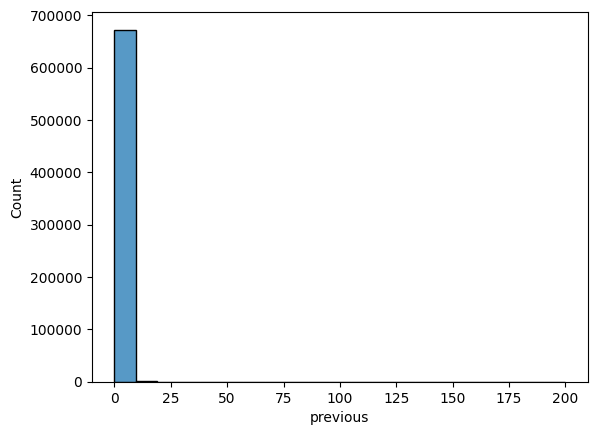

In [11]:
sns.histplot(X_train[num_features2[0]])

<Axes: xlabel='campaign', ylabel='Count'>

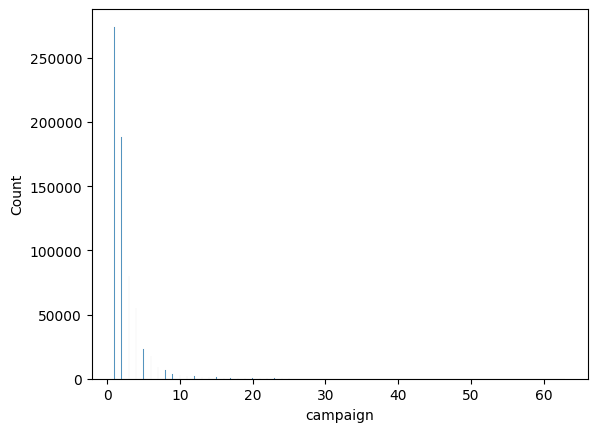

In [12]:
sns.histplot(X_train[num_features2[1]])

<Axes: xlabel='pdays', ylabel='Count'>

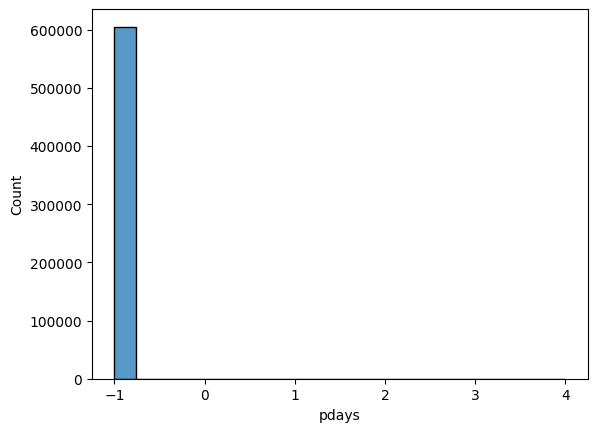

In [13]:
sns.histplot(X_train[X_train[num_features2[2]] < 5][num_features2[2]])

<Axes: xlabel='duration', ylabel='Count'>

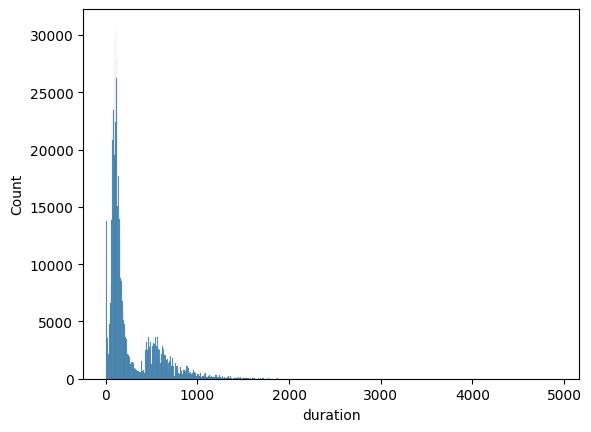

In [14]:
sns.histplot(X_train[num_features2[3]])

In [15]:
num_features1 = list(set(num_features_names) - set(num_features2))
num_features1

['balance', 'age']

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [17]:
num_features_names

['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

In [18]:
num_features2

['previous', 'campaign', 'pdays', 'duration']

In [90]:
num_features1 += ['day']

In [91]:
cat_features_names += ['month']

In [111]:
num_features1.remove('day')

In [128]:
cat_features_names.remove('month')

In [129]:
from castom_transformers import *
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
my_pipe_line = Pipeline([
    # фильтруем
    ('filter', Percentile_filter(columns=num_features_names)),


    # transform
    ('percentile_transform', Percentile_transform(columns=['balance'])),


    ('columns_transformer', ColumnTransformer([

        # Вот тут пайплайн для численных, где нужно логарифмирование
        ('log_scaler', Pipeline([
            ('log', MyLog1p()),
            ('scaler', StandardScaler())
        ]), num_features2),


        # численные, просто стандартизация
        ('scaler', StandardScaler(), num_features1),



        # работа со временем
        ('data', timestamp_transformer, date_features),


        # cat features
        ('ohe', OneHotEncoder(drop='first', sparse_output=False), cat_features_names)


    ], remainder='passthrough', verbose_feature_names_out=False,
    n_jobs=-1)),

    # KNN imputer
    ('imputer', KNNImputer(n_neighbors=10))
])

In [21]:
hasattr(X_train, 'index')

True

In [22]:
my_x = X_train.copy()

In [23]:
finish_ = FinishPipeline(my_pipe_line, cat_features_names=cat_features_names)

In [100]:
len(cat_features_names)

9

In [101]:
finish_ = FinishPipeline(my_pipe_line, cat_features_names=cat_features_names)
# a, b = finish_.fit_transform(X=X_train, y=y_train)

KeyboardInterrupt: 

In [25]:
a.dtypes

previous             float64
campaign             float64
pdays                float64
duration             float64
balance              float64
age                  float64
timestamp            float64
threshold_balance    float64
job                   object
marital               object
education             object
default               object
housing               object
loan                  object
contact               object
poutcome              object
dtype: object

In [26]:
b

125791    0
735523    0
698949    0
571287    1
243324    1
         ..
507303    0
298049    0
612958    0
154176    1
729634    0
Name: y, Length: 675000, dtype: int64

In [27]:
a1, b1 = finish_.transform(X_val, y_val)

In [28]:
# X_train_pr = my_pipe_line.fit_transform(X_train)
# y_train_pr = y_train.loc[X_train_pr.index]
# ohe = my_pipe_line.named_steps['columns_transformer']\
#                                 .named_transformers_['ohe']\

# new_columns = ohe.get_feature_names_out()
# d_cat = X_train_pr[new_columns]
# new_cat = ohe.inverse_transform(X_train_pr[new_columns])
# new_cat = pd.DataFrame(new_cat, columns=cat_features_names, index=d_cat.index)
# X_train_pr = X_train_pr.drop(columns=new_columns).join(new_cat)

In [29]:

X_train_pr, X_val_pr, y_train_pr, y_val_pr = a, a1, b, b1


In [30]:
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import roc_auc_score
model = CatBoostClassifier(
    custom_loss=[metrics.AUC()],
    random_seed=random_seed,
    logging_level='Silent',
)


In [31]:
full_preprocessor = Pipeline([
    ('preprocessor', FinishPipeline(my_pipe_line, cat_features_names=cat_features_names)),
    ('model', CatBoostClassifier(
    custom_loss=[metrics.AUC()],
    random_seed=random_seed,
    logging_level='Silent',
))
])

# full_preprocessor.fit(
#     X_train, y_train,
#     model__cat_features=cat_features_names,
#     model__eval_set=[(X_val, y_val)],
#     # logging_level='Verbose',  # you can uncomment this for text output
#     model__plot=True,
#     model__use_best_model=True
# );

In [32]:
# !pip install hyperopt

In [33]:
import hyperopt

def hyperopt_objective(params):
    full_preprocessor = Pipeline([
    ('preprocessor', FinishPipeline(my_pipe_line, cat_features_names=cat_features_names)),
    ('model', CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=500,
        eval_metric=metrics.AUC(),
        random_seed=42,
        verbose=False,
        loss_function=metrics.Logloss(),
    ))
])


    cv_data = cv(
        Pool(df, y, cat_features=cat_features_names),
        full_preprocessor.named_steps['model'].get_params(),
        logging_level='Silent',
    )
    best_auc = np.max(cv_data['test-AUC-mean'])

    return 1 - best_auc # as hyperopt minimises

In [ ]:
import hyperopt

def hyperopt_objective(params):
    x_pr, y_pr = FinishPipeline(my_pipe_line, cat_features_names=cat_features_names).fit_transform(df, y)
#     full_preprocessor = Pipeline([
#     ('preprocessor', FinishPipeline(my_pipe_line, cat_features_names=cat_features_names)),
#     ('model', CatBoostClassifier(
#         l2_leaf_reg=int(params['l2_leaf_reg']),
#         learning_rate=params['learning_rate'],
#         iterations=500,
#         eval_metric=metrics.AUC(),
#         random_seed=42,
#         verbose=False,
#         loss_function=metrics.Logloss(),
#     ))
# ])
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=500,
        eval_metric=metrics.AUC(),
        random_seed=42,
        verbose=False,
        loss_function=metrics.Logloss(),
    )

    cv_data = cv(
        Pool(x_pr, y_pr, cat_features=cat_features_names),
        model.get_params(),
        logging_level='Silent',
    )
    best_AUC = np.max(cv_data['test-AUC-mean'])

    return 1 - best_AUC
    # return 1 - scores.mean() # as hyperopt minimises


from numpy.random import default_rng

params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=default_rng(123)
)

print(best)

In [130]:
model = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    iterations=500,
    eval_metric=metrics.AUC(),
    random_seed=42,
    verbose=False,
    loss_function=metrics.Logloss(),
)


In [131]:
prepr = FinishPipeline(my_pipe_line, cat_features_names=cat_features_names)

In [133]:
X, y= prepr.fit_transform(df, y)
model.fit(X, y, cat_features=cat_features_names, plot=True, )

/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [120]:
# import pickle

# with open('cat_boost_with_tuning.pkl', 'wb') as f:
#     pickle.dump(model, f)

In [121]:
# with open('best_for_catboost.pkl', 'wb') as f:
#     pickle.dump(best, f)

------------------------------  
------------------------------

In [134]:
test_df = pd.read_csv('test.csv')

In [135]:
ids_test = test_df['id']
test_df.drop('id', axis=1, inplace=True)

In [136]:
test_df_pr = finish_.transform(test_df)

ValueError: Shape of passed values is (250000, 9), indices imply (250000, 8)

In [ ]:
test_pred_prob = model.predict_proba(test_df_pr)
submisstion = pd.DataFrame()
submisstion['id'] = ids_test
submisstion['y'] = test_pred_prob[:, 1]
submisstion.to_csv('submission.csv', index=False)

In [ ]:
!kaggle competitions submit -c playground-series-s5e8 -f submission.csv -m "Message"

100%|██████████████████████████████████████| 6.63M/6.63M [00:01<00:00, 3.63MB/s]
Successfully submitted to Binary Classification with a Bank Dataset

In [127]:
best

{'l2_leaf_reg': np.float64(2.0),
 'learning_rate': np.float64(0.3229227220314057)}

In [110]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome'],
      dtype='object')